In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from anchor.visualize import MODALITY_TO_COLOR, MODALITY_ORDER, MODALITY_PALETTE
modality_order = MODALITY_ORDER

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

%load_ext autoreload
%autoreload 2

folder = 'pdfs'#'/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure4_voyages'

import flotilla

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'
study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-05-13 11:01:21	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-05-13 11:01:21	Parsing datapackage to create a Study object
2016-05-13 11:01:52	Initializing Study
2016-05-13 11:01:53	Initializing Predictor configuration manager for Study
2016-05-13 11:01:53	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-05-13 11:01:53	Added ExtraTreesClassifier to default predictors
2016-05-13 11:01:53	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-05-13 11:01:53	Added ExtraTreesRegressor to default predictors
2016-05-13 11:01:53	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-05-13 11:01:53	Added GradientBoostingClassifier to default predic

/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:55: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


In [15]:
study.splicing.minimum_samples

10

In [16]:
study.splicing.feature_expression_id_col = 'ensembl_id'

In [17]:
study.supplemental.modalities_tidy = study.supplemental.modalities_tidy.replace(
    {'modality': {'ambivalent': 'uncategorized', 'concurrent': 'middle'}})

In [18]:
not_excluded_included = 'bimodal', 'middle', 'uncategorized'

In [33]:
import six

In [40]:
go_dfs = []
feature_dfs = []

for phenotype, df in study.supplemental.modalities_tidy.groupby('phenotype'):
    background_events = df['event_id']
    modalities = df.query('modality in @not_excluded_included')
    foreground_events = modalities['event_id']
    
    feature_data = study.splicing.feature_data.loc[foreground_events, ['ensembl_id', 'gene_name']]
    feature_data = feature_data.join(study.expression.feature_data[['gerstberger2014_tf', 'gerstberger2014_rbp']], 
                                     on='ensembl_id')
#     feature_data['phenotype'] = phenotype
    feature_data = feature_data.join(modalities.set_index('event_id'))
    feature_dfs.append(feature_data)
    
    background_genes = study.splicing.splicing_to_expression_id(background_events)
    foreground_genes = study.splicing.splicing_to_expression_id(foreground_events)
    
    go_df = study.go_enrichment(foreground_genes, background=background_genes, domain='biological_process', 
                                min_background_size=10, min_feature_size=5)
    go_df['phenotype'] = phenotype
    six.print_('\n---\n{}\n'.format(phenotype), go_df[['go_name', 'bonferonni_corrected_negative_log_p_value']].head(10))
    go_dfs.append(go_df.reset_index())
    
metadata = pd.concat(feature_dfs)
go = pd.concat(go_dfs)
go.head()


---
MN
                                              go_name  \
GO:0008152                         metabolic process   
GO:0006351              transcription, DNA-dependent   
GO:0042384                           cilium assembly   
GO:0006397                           mRNA processing   
GO:0006396                            RNA processing   
GO:0008380                              RNA splicing   
GO:0007420                         brain development   
GO:0006468                   protein phosphorylation   
GO:0043066  negative regulation of apoptotic process   
GO:0007165                       signal transduction   

            bonferonni_corrected_negative_log_p_value  
GO:0008152                                  11.246087  
GO:0006351                                   9.903550  
GO:0042384                                   9.250744  
GO:0006397                                   8.249405  
GO:0006396                                   8.243365  
GO:0008380                            

,index,features_of_interest_in_go_term,features_of_interest_in_go_term_gene_symbols,go_domain,go_name,n_background_in_go_term,n_features_of_interest_in_go_term,n_features_total_in_go_term,negative_log_p_value,bonferonni_corrected_negative_log_p_value,phenotype
0,GO:0008152,"ENSG00000198130,ENSG00000072210,ENSG0000007523...","HIBCH,ALDH3A2,ACAT1,ECHDC1,HSD17B10,ACADM,LYPL...",biological_process,metabolic process,51,29,486,16.416571,11.246087,MN
1,GO:0006351,"ENSG00000124177,ENSG00000124151,ENSG0000019722...","CHD6,NCOA3,C1D,TAF1B,NCOA4,PBX1,ASCC1,TRIM33,K...",biological_process,"transcription, DNA-dependent",216,83,2018,15.074034,9.903550,MN
2,GO:0042384,"ENSG00000144451,ENSG00000135541,ENSG0000019870...","SPAG16,AHI1,CEP290,PCM1,CCDC28B,IQCB1,BBIP1,SE...",biological_process,cilium assembly,10,9,71,14.421228,9.250744,MN
3,GO:0006397,"ENSG00000151657,ENSG00000185946,ENSG0000017393...","KIN,RNPC3,RBM4,LUC7L3,XRN2,SRSF7,PTBP2,SNRPB,M...",biological_process,mRNA processing,73,35,240,13.419889,8.249405,MN
4,GO:0006396,"ENSG00000090621,ENSG00000131051,ENSG0000009674...","PABPC4,RBM39,HNRNPH3,RBM5,PRPF39,RBM4,DUSP11,X...",biological_process,RNA processing,31,19,97,13.413849,8.243365,MN


In [28]:
metadata.head()

,ensembl_id,gene_name,gerstberger2014_tf,gerstberger2014_rbp,phenotype,modality
event_id,,,,,,
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,ENSG00000014919,COX15,False,False,MN,bimodal
exon:chr10:102747070-102747240:-@exon:chr10:102746847-102746953:-@exon:chr10:102746506-102746732:-,ENSG00000055950,MRPL43,False,True,MN,bimodal
exon:chr10:103113864-103113985:+@exon:chr10:103190102-103190209:+@exon:chr10:103221738-103221815:+,ENSG00000166167,BTRC,False,False,MN,bimodal
exon:chr10:103360960-103361093:+@exon:chr10:103364897-103364969:+@exon:chr10:103368592-103368694:+,ENSG00000166171,DPCD,False,False,MN,bimodal
exon:chr10:103360960-103361093:+@exon:chr10:103368592-103368694:+@exon:chr10:103369124-103369196:+,ENSG00000166171,DPCD,False,False,MN,bimodal


In [38]:
plot_go_enrichment?

/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/visualize/gene_ontology.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data[x_col] = data[x_col].replace(0, np.nan)


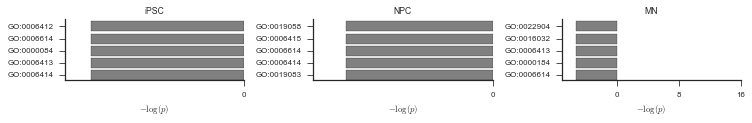

In [39]:
from flotilla.visualize.gene_ontology import plot_go_enrichment

sns.set(style='ticks', context='paper')

g = sns.FacetGrid(go, col='phenotype', aspect=2, size=1.75, sharey=False, col_order=study.phenotype_order)
g.map_dataframe(plot_go_enrichment, 'bonferonni_corrected_negative_log_p_value', max_categories=5, color='grey', 
                yticklabels='index')
g.set_titles('{col_name}')
g.set_xlabels('$-\log(p)$')
ax = plt.gca()
ax.set(xticks=[0, 8, 16]);
g.fig.savefig('{}/bimodal_go_enrichment.pdf'.format(folder))

In [22]:
go.head()

,index,features_of_interest_in_go_term,features_of_interest_in_go_term_gene_symbols,go_domain,go_name,n_background_in_go_term,n_features_of_interest_in_go_term,n_features_total_in_go_term,p_value,bonferonni_corrected_p_value,phenotype
0,GO:0050885,"ENSG00000007168,ENSG00000179915,ENSG0000020412...","PAFAH1B1,NRXN1,GIGYF2,BCR,MYH10",biological_process,neuromuscular process controlling balance,5,5,42,0,0,MN
1,GO:0045862,"ENSG00000198408,ENSG00000166167,ENSG0000010105...","MGEA5,BTRC,IFT52,HDAC2,IFT88",biological_process,positive regulation of proteolysis,5,5,14,0,0,MN
2,GO:0060041,"ENSG00000123349,ENSG00000134982,ENSG0000019870...","PFDN5,APC,CEP290,IMPDH2,MYH10",biological_process,retina development in camera-type eye,5,5,55,0,0,MN
3,GO:0032968,"ENSG00000140395,ENSG00000196235,ENSG0000015458...","WDR61,SUPT5H,TCEB1,LEO1,EAPP",biological_process,positive regulation of transcription elongatio...,5,5,12,0,0,MN
4,GO:0007224,"ENSG00000147383,ENSG00000032742,ENSG0000010057...","NSDHL,IFT88,KIAA0586,IFT52,SEPT2,KIF3A",biological_process,smoothened signaling pathway,6,6,53,0,0,MN


In [23]:
go['features_of_interest_in_go_term_gene_symbols'] = go['features_of_interest_in_go_term_gene_symbols'].map(lambda x: ','.join(sorted(x.split(','))))

In [24]:
go.to_csv('bimodal_middle_uncategorized_go_enrichment.csv', index=False)

In [25]:
metadata.head()

,ensembl_id,gene_name,gerstberger2014_tf,gerstberger2014_rbp,phenotype,modality
event_id,,,,,,
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,ENSG00000014919,COX15,False,False,MN,bimodal
exon:chr10:102747070-102747240:-@exon:chr10:102746847-102746953:-@exon:chr10:102746506-102746732:-,ENSG00000055950,MRPL43,False,True,MN,bimodal
exon:chr10:103113864-103113985:+@exon:chr10:103190102-103190209:+@exon:chr10:103221738-103221815:+,ENSG00000166167,BTRC,False,False,MN,bimodal
exon:chr10:103360960-103361093:+@exon:chr10:103364897-103364969:+@exon:chr10:103368592-103368694:+,ENSG00000166171,DPCD,False,False,MN,bimodal
exon:chr10:103360960-103361093:+@exon:chr10:103368592-103368694:+@exon:chr10:103369124-103369196:+,ENSG00000166171,DPCD,False,False,MN,bimodal


In [26]:
metadata.to_csv('bimodal_middle_uncategorized_metadata.csv')